# Diabetes Prediction Tool

### Aim: 
The aim of this project is to process the data using pyspark and develop Diabetes Prediction Tool
### Input
1. rel.csv

    In this dataset, each line is a pair of strings separated with comma, where each line
    represents certain relations between two biomedical concepts in the Unified Medical Language System
   (UMLS). Formally, each line can be represented as a concept pair (c1, c2)
   
   
2. diabetes.csv

    This dataset will be used for diabetes prediction. It consists of 9 variables (or features),
    where the first 8 variables are predictor (independent) variables, and the last variable “Outcome” is the target
    (dependent) variable we are going to predict (1 means the patient is diabetic, and 0 means not). Independent
    variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on

### Output:
Develop machine learning models that predict the diabetes

In [43]:
#Import required libararies
%config IPCompleter.use_jedi = False
import pyspark
import pyspark.mllib.stat as st
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
from pyspark.sql.types import IntegerType
import pyspark.ml.classification as cl
import pyspark.ml.tuning as tune

from pyspark.ml import Pipeline

import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [44]:
#check the sparkcontext
sc

<SparkContext master=local[*] appName=PySparkShell>

# Data Preparation

### Prepare rel.csv dataset

In [25]:
# Read CSV files
rel_df=spark.read.csv("./data/rel.csv",header="False")

#check dataframe
rel_df.show(1)
rel_df.printSchema()

+--------+--------+
|     _c0|     _c1|
+--------+--------+
|C0005790|C0005778|
+--------+--------+
only showing top 1 row

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [26]:
#Order the pair of string using lamda function and convert it to rdd
rel_sorted=rel_df.rdd.map(lambda x: sorted (x))

In [27]:
#check first 5 values
rel_sorted.take(5)

[['C0005778', 'C0005790'],
 ['C1255279', 'C3537249'],
 ['C0002520', 'C1255446'],
 ['C0596019', 'C1255552'],
 ['C0004611', 'C1254417']]

In [29]:
#Convert rel_sorted to df again
df_rel=rel_sorted.toDF()

In [30]:
#Check schema
df_rel.printSchema()

#Check first 2 rows
df_rel.show(2)

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)

+--------+--------+
|      _1|      _2|
+--------+--------+
|C0005778|C0005790|
|C1255279|C3537249|
+--------+--------+
only showing top 2 rows



In [35]:
#ordered pair count
count_rel_pairs=df_rel.groupBy(["_1","_2"]).count()

#use orderby function
rel_pairs=count_rel_pairs.orderBy(["_1","_2"], ascending=True)

In [40]:
#show instance of each ordered pair
rel_pairs.show()

+--------+--------+-----+
|      _1|      _2|count|
+--------+--------+-----+
|C0000005|C0036775|    4|
|C0000039|C0000039|   22|
|C0000039|C0001555|    2|
|C0000039|C0001688|    2|
|C0000039|C0002776|    2|
|C0000039|C0003139|    2|
|C0000039|C0005572|    2|
|C0000039|C0005768|    2|
|C0000039|C0007807|    2|
|C0000039|C0007987|    2|
|C0000039|C0008903|    2|
|C0000039|C0011933|    2|
|C0000039|C0012456|   22|
|C0000039|C0013557|    2|
|C0000039|C0017399|    2|
|C0000039|C0019665|    2|
|C0000039|C0022189|    2|
|C0000039|C0025520|    2|
|C0000039|C0031328|    2|
|C0000039|C0031610|    4|
+--------+--------+-----+
only showing top 20 rows



In [41]:
import shutil

filePath = 'pair-count.txt'
# remove dir and subdirectories if filePath exists
if os.path.exists(filePath):
    shutil.rmtree(filePath) 

rel_pairs.rdd.saveAsTextFile( filePath )

In [47]:
rel_pairs.rdd.map(lambda a:str(a[0] + "\t" + str (a[1])+ "\t" +str(a[2])))\
.saveAsTextFile("pair-count.txt1")

###  Count the total number of ordered pairs, that is, how many unique ordered pairs are obtained

In [39]:
print('Total number of ordered pairs: {0}'.format(rel_pairs.count()))

Total number of ordered pairs: 12946540


### diabetes.csv dataset

In [43]:
import pyspark
import pyspark.mllib.stat as st
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
import pyspark.ml.classification as cl
import pyspark.ml.tuning as tune
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [44]:
# Read CSV files
df=spark.read.csv("./data/diabetes.csv",header="true")

#check dataframe
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [45]:
#Count number of rows in dataframe
print(f'Number of rows: {df.count()}')

Number of rows: 768


In [46]:
#Check schema of dataframe
df.printSchema()

root
 |-- Pregnancies: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- BloodPressure: string (nullable = true)
 |-- SkinThickness: string (nullable = true)
 |-- Insulin: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- DiabetesPedigreeFunction: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Outcome: string (nullable = true)



In [47]:
# Load data providing a schema and convert datatype to integer or float

labels = [
    ('Pregnancies', typ.IntegerType()),
    ('Glucose', typ.StringType()),
    ('BloodPressure', typ.IntegerType()),
    ('SkinThickness', typ.IntegerType()),
    ('Insulin', typ.IntegerType()),
    ('BMI', typ.FloatType()),
    ('DiabetesPedigreeFunction', typ.FloatType()),
    ('Age', typ.IntegerType()),
    ('Outcome', typ.IntegerType()),
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])

dm_df = spark.read.csv('./assignment3-data/data/diabetes.csv', 
                        header=True, 
                        schema=schema)

In [48]:
#Check schema after data type change
dm_df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: float (nullable = true)
 |-- DiabetesPedigreeFunction: float (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [49]:
# cast a column to a new type after loading the data

dm_df = dm_df \
    .withColumn('Glucose', 
                dm_df['Glucose'] \
                    .cast(typ.IntegerType()))

dm_df.dtypes

[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'float'),
 ('DiabetesPedigreeFunction', 'float'),
 ('Age', 'int'),
 ('Outcome', 'int')]

In [50]:
#Check columns
dm_df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 2 rows



### Step 1  Remove the rows where the “BloodPressure”, “BMI” and “Glucose” columns are zero

In [51]:
#Fiter values
final_df=dm_df.filter((dm_df.BloodPressure >0) & (dm_df.Glucose > 0) & (dm_df.BMI >0))

#Print number of rows where Bloodpressure, glucose, and BMI don't have zero values
print('Number of rows where BloodPressure,Glucose, and BMI dont have zero value: {0}'.format(final_df.count()))

Number of rows where BloodPressure,Glucose, and BMI dont have zero value: 724


In [52]:
#Check the summary of all three columns
final_df.select("BloodPressure", "Glucose", "BMI").describe().show()

+-------+------------------+------------------+-----------------+
|summary|     BloodPressure|           Glucose|              BMI|
+-------+------------------+------------------+-----------------+
|  count|               724|               724|              724|
|   mean| 72.40055248618785|121.88259668508287|32.46712707814591|
| stddev|12.379870321719064|30.750029983865353|6.888940896003464|
|    min|                24|                44|             18.2|
|    max|               122|               199|             67.1|
+-------+------------------+------------------+-----------------+



###  Step 2  Convert the categorical column “Pregnancies” into one-hot encoding.

In [77]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator

In [73]:
preg_indexer=StringIndexer(inputCol="Pregnancies", 
    outputCol="PregnanciesIndex")

df13=preg_indexer.fit(final_df).transform(final_df)
df13.show(2)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|PregnanciesIndex|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|             6.0|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|             0.0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+
only showing top 2 rows



In [89]:
encoders = OneHotEncoderEstimator(
    inputCols=["Pregnancies"], 
    outputCols=["Pregnancies_VEC"])

In [90]:
dmModel=encoders.fit(df13)
preganciesTr=dmModel.transform(df13)
preganciesTr.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+---------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|PregnanciesIndex|Pregnancies_VEC|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+---------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|             6.0| (17,[6],[1.0])|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|             0.0| (17,[1],[1.0])|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+---------------+
only showing top 2 rows



###  Step 3  Create a single column with all the features collated together using VectorAssembler.

In [91]:
inputCols=[
        "Glucose" ,
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
        "Pregnancies_VEC"
      ]
outputCol ='features'
featuresCreator = ft.VectorAssembler (inputCols=inputCols, outputCol=outputCol)

In [92]:
res = featuresCreator.transform(preganciesTr).take(2)
res

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.599998474121094, DiabetesPedigreeFunction=0.6269999742507935, Age=50, Outcome=1, PregnanciesIndex=6.0, Pregnancies_VEC=SparseVector(17, {6: 1.0}), features=SparseVector(24, {0: 148.0, 1: 72.0, 2: 35.0, 4: 33.6, 5: 0.627, 6: 50.0, 13: 1.0})),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.600000381469727, DiabetesPedigreeFunction=0.35100001096725464, Age=31, Outcome=0, PregnanciesIndex=0.0, Pregnancies_VEC=SparseVector(17, {1: 1.0}), features=SparseVector(24, {0: 85.0, 1: 66.0, 2: 29.0, 4: 26.6, 5: 0.351, 6: 31.0, 8: 1.0}))]

In [93]:
res[0][-1]

SparseVector(24, {0: 148.0, 1: 72.0, 2: 35.0, 4: 33.6, 5: 0.627, 6: 50.0, 13: 1.0})

### Step 4 Random split the collated data into training (70%) and testing (30%) datasets and use 2017 as the seed. 

In [94]:
dm_train, dm_test = final_df \
    .randomSplit([0.7, 0.3], seed=2017)

### Step 5  Implement a random forest classifier and specify the number of decision trees as 20. 

In [95]:
import pyspark.sql.functions as func

final_df = final_df.withColumn(
    'Outcome', 
    func.col('Outcome').cast(typ.DoubleType())
)

dm_train, dm_test = final_df \
    .randomSplit([0.7, 0.3], seed=2017)

In [97]:
classifier = cl.RandomForestClassifier(
    numTrees=20, 
    maxDepth=5, 
    labelCol='Outcome')

pipeline = Pipeline(
    stages=[
        encoders,
        featuresCreator, 
        classifier])

model = pipeline.fit(dm_train)
test = model.transform(dm_test)

In [98]:
test.take(1)

[Row(Pregnancies=0, Glucose=67, BloodPressure=76, SkinThickness=0, Insulin=0, BMI=45.29999923706055, DiabetesPedigreeFunction=0.1940000057220459, Age=46, Outcome=0.0, Pregnancies_VEC=SparseVector(17, {0: 1.0}), features=SparseVector(24, {0: 67.0, 1: 76.0, 4: 45.3, 5: 0.194, 6: 46.0, 7: 1.0}), rawPrediction=DenseVector([16.301, 3.699]), probability=DenseVector([0.8151, 0.1849]), prediction=0.0)]

#### Model performance 

In [99]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='Outcome')

print('AuROC', evaluator.evaluate(test, 
     {evaluator.metricName: 'areaUnderROC'}))
print('AuPR', evaluator.evaluate(test, {evaluator.metricName: 'areaUnderPR'}))

AuROC 0.8638709677419356
AuPR 0.7650261402900278


### Step 6  Evaluate the performance of the random forest classifier using the ROC curve metric. 

In [100]:
import sklearn.metrics as sk_me

test.select('probability','Outcome').take(5)

[Row(probability=DenseVector([0.8151, 0.1849]), Outcome=0.0),
 Row(probability=DenseVector([0.8686, 0.1314]), Outcome=0.0),
 Row(probability=DenseVector([0.8365, 0.1635]), Outcome=0.0),
 Row(probability=DenseVector([0.8408, 0.1592]), Outcome=0.0),
 Row(probability=DenseVector([0.862, 0.138]), Outcome=0.0)]

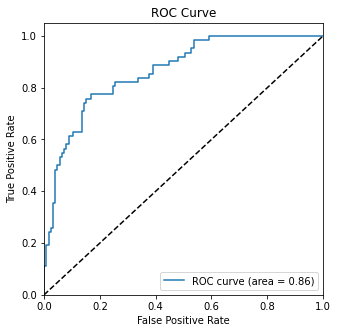

In [101]:
probArr = test.select('probability','Outcome') \
                    .rdd \
                    .map( lambda row: [row[0][1], row[1]] ).collect()
probArr = np.array(probArr)

fpr, tpr, thresholds = sk_me.roc_curve( probArr[:,1], probArr[:,0], pos_label=1)
roc_auc = sk_me.auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()